# What is Collaborative Filtering?

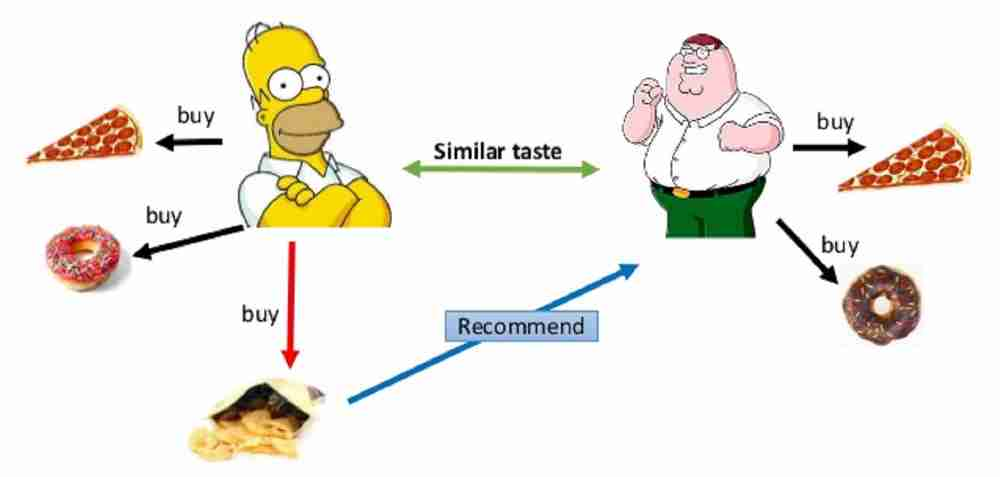

In [6]:
Image('intro.jpeg')

Collaborative filtering is the predictive process behind recommendation engines. Recommendation engines analyze information about users with similar tastes to assess the probability that a target individual will enjoy something.

Collaborative filtering uses algorithms to filter data from user reviews to make personalized recommendations for users with similar preferences. Collaborative filtering is also used to select content and advertising for individuals on social media.

Collaborative filtering filters information by using the interactions and data collected by the system from other users. For example when we want to find a new movie to watch we'll often ask our friends for recommendations.

Naturally, we have greater trust in the recommendations from friends who share tastes similar to our own. Collaborative filtering does the same job. Collaborative filtering mostly focuses on finding similarity between users and recommend each other their likes. There are various ways to find the similarity measure : Cosine similarity, Pearson similarity, Jaccard similarity etc.

# Importing required libraries

In [9]:
# Installing surprise Library
!pip install surprise

  Using cached openpyxl-3.0.10-py2.py3-none-any.whl (242 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [1]:
# Importing basic libraries
import pandas as pd
import numpy as np
import random

# Importing scipy.sparse.csr_matrix for kNN data preparation
from scipy.sparse import csr_matrix

# Importing kNN algorithm
from sklearn.neighbors import NearestNeighbors

# Importing cosine_similarity to calculate cosine similarity in memory based collaborative filtering
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Importing surprise.Reader,Dataset for surprise data preparation
from surprise import Reader, Dataset

# Importing for surprise model customizations
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

ModuleNotFoundError: No module named 'surprise'

In [3]:
# Importing algorithms from Surprise package
from surprise.prediction_algorithms import NMF,CoClustering,SVD

# Importing accuracy to get metrics such as RMSE and MAE
from surprise import accuracy

ModuleNotFoundError: No module named 'surprise'

# Importing the dataset as data

In [4]:
data = pd.read_excel('Rec_sys_data.xlsx')

In [5]:
data.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


## About the Dataset

The 8 columns or features are as:
1. InvoiceNo : The invoice number of particular transaction
2. StockCode : The unique code for particular item
3. Descripion : The description of particular item
4. Quantity : The quantity of particular item bought by the customer
5. InvoiceDate : The date and time when the transaction was made
6. UnitPrice : The price of 1 unit of particular item
7. CustomerID : The unique id of customer who bought the item
8. Country : The country or region of the customer

In [6]:
data.shape

(272404, 9)

The dataset has 5,41,909 rows and 8 columns.
In other words, the dataset contains 5,41,909 unique transactions.

In [7]:
data.isnull().sum().sort_values(ascending=False)

InvoiceNo       0
StockCode       0
Quantity        0
InvoiceDate     0
DeliveryDate    0
Discount%       0
ShipMode        0
ShippingCost    0
CustomerID      0
dtype: int64

Out of 541909 records, 135080 records are missing CustomerID and 1454 have no Description.

Since we have to perform Collaborative Filtering, we need both these values to establish relations based on User behavior so we have to drop NAN records.

In [8]:
data1 = data.dropna()

In [9]:
data1.describe()

,InvoiceNo,Quantity,Discount%,ShippingCost,CustomerID
count,272404.000000,272404.000000,272404.000000,272404.000000,272404.000000
mean,553740.733319,13.579536,0.300092,17.053491,15284.323523
std,9778.082879,149.136756,0.176023,10.013210,1714.478624
min,536365.000000,1.000000,0.000000,5.810000,12346.000000
25%,545312.000000,2.000000,0.150000,5.810000,13893.000000
50%,553902.000000,6.000000,0.300000,15.220000,15157.000000
75%,562457.000000,12.000000,0.450000,30.120000,16788.000000
max,569629.000000,74215.000000,0.600000,30.120000,18287.000000


Here we can see quantity has some negative values which is a part of incorrect data so we will drop such entries

In [10]:
data1 = data1[data1.Quantity > 0]

In [11]:
data1.describe()

,InvoiceNo,Quantity,Discount%,ShippingCost,CustomerID
count,272404.000000,272404.000000,272404.000000,272404.000000,272404.000000
mean,553740.733319,13.579536,0.300092,17.053491,15284.323523
std,9778.082879,149.136756,0.176023,10.013210,1714.478624
min,536365.000000,1.000000,0.000000,5.810000,12346.000000
25%,545312.000000,2.000000,0.150000,5.810000,13893.000000
50%,553902.000000,6.000000,0.300000,15.220000,15157.000000
75%,562457.000000,12.000000,0.450000,30.120000,16788.000000
max,569629.000000,74215.000000,0.600000,30.120000,18287.000000


In [12]:
data1.shape

(272404, 9)

In [13]:
    data1.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


Our final dataset now has 397924 records which are clean and complete.

In [14]:
data1.StockCode = data1.StockCode.astype(str)

# Memory-Based Approach

In Memory-Based approach, the closest user or items are calculated only by using Cosine similarity or Pearson correlation coefficients, which are only based on arithmetic operations.

A common distance metric is cosine similarity. The metric can be thought of geometrically if one treats a given user’s (item’s) row (column) of the ratings matrix as a vector. For user-based collaborative filtering, two users’ similarity is measured as the cosine of the angle between the two users’ vectors. For users u and u′, the cosine similarity is:



As no training or optimization is involved, it is an easy to use approach. But its performance decreases when we have sparse data which hinders scalability of this approach for most of the real-world problems.

Memory-Based approach is further divided into :
1. User-to-User Collaborative Filtering
2. Item-to-Item Collaborative Filtering

## User-to-User Collaborative Filtering

User-Based Collaborative Filtering is a technique used to predict the items that a user might like on the basis of ratings given to that item by the other users who have similar taste with that of the target user.

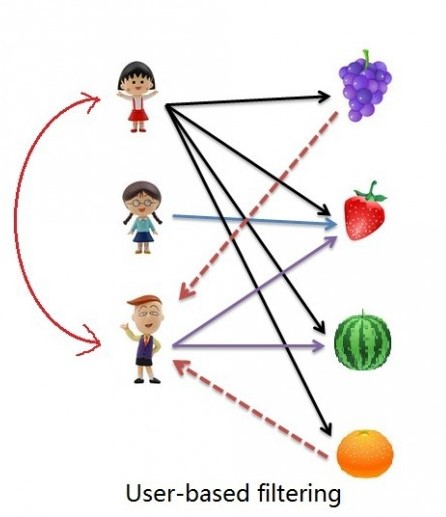

In [14]:
Image('User_based1.jpeg')

In User-Based Collaborative Filtering, we create a matrix that describes behaviour of all users corresponding to all the items.
Further, we build relation between mutiple users to identify the similar users.

### Implementation

We are creating a data(matrix) which contains CustomerID and whether they have ever purchased a product using groupby.

In [15]:
purchase_df = (data1.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('CustomerID'))

In [16]:
purchase_df.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0


We are getting the quantity ordered (example : 48,24,126) while we just want to know if that particular item is purchased or not. 

Thus we need to do encoding as 1(if purchased) or 0(not purchased)


In [17]:
def encode_units(x):
    if x < 1: # If the quantity is less than 1
        return 0 # Not purchased
    if x >= 1: # If the quantity is greater than 1
        return 1 # Purchased


purchase_df = purchase_df.applymap(encode_units)

In [18]:
purchase_df.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


The purchase matrix is now ready, which describes the behaviour of Customers corresponding to all the items.

We can now apply Collaborative filtering on it.

In [19]:
# Applying cosine_similarity on the purchase matrix
user_similarities = cosine_similarity(purchase_df)

In [20]:
# Storing the similarity scores in a dataframe, i.e., the similarity scores matrix
user_similarity_data = pd.DataFrame(user_similarities,index=purchase_df.index,columns=purchase_df.index)

In [21]:
user_similarity_data.head()

CustomerID,12346,12347,12348,12350,12352,12353,12354,12355,12356,12358,...,18269,18270,18272,18273,18278,18280,18281,18282,18283,18287
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.114708,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
12347,0.0,1.000000,0.070632,0.053567,0.048324,0.0,0.029001,0.091885,0.075845,0.000000,...,0.041739,0.000000,0.050669,0.0,0.036811,0.069843,0.0,0.0,0.087667,0.021253
12348,0.0,0.070632,1.000000,0.051709,0.031099,0.0,0.027995,0.118262,0.146427,0.061546,...,0.000000,0.000000,0.024456,0.0,0.000000,0.000000,0.0,0.0,0.123091,0.082061
12350,0.0,0.053567,0.051709,1.000000,0.035377,0.0,0.000000,0.000000,0.033315,0.070014,...,0.000000,0.000000,0.027821,0.0,0.000000,0.000000,0.0,0.0,0.052511,0.000000
12352,0.0,0.048324,0.031099,0.035377,1.000000,0.0,0.095765,0.040456,0.100180,0.084215,...,0.110264,0.065233,0.133855,0.0,0.000000,0.000000,0.0,0.0,0.094742,0.056143


This is how the user_similarity_data looks like. It contains the similarity score of users with 0 being the least similar while 1 being the most similar.

#### Making Recommendations

In [22]:
def fetch_similar_users(user_id,k=5):
    # separating data rows for the entered user id
    user_similarity = user_similarity_data[user_similarity_data.index == user_id]
    
    # a data of all other users
    other_users_similarities = user_similarity_data[user_similarity_data.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user_similarity,other_users_similarities)[0].tolist()
    
    # create list of indices of these users
    user_indices = other_users_similarities.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity_pair = dict(zip(user_indices, similarities))
    
    # sort by similarity
    sorted_index_similarity_pair = sorted(index_similarity_pair.items(),reverse=True)
    
    # grab k users off the top
    top_k_users_similarities = sorted_index_similarity_pair[:k]
    similar_users = [u[0] for u in top_k_users_similarities]
    
    print('The users with behaviour similar to that of user {0} are:'.format(user_id))
    return similar_users

In [23]:
similar_users = fetch_similar_users(12347)
similar_users

The users with behaviour similar to that of user 12347 are:


[18287, 18283, 18282, 18281, 18280]

Further the similar users can be stored in a list and later we can display the items purchased by the similar users as done below

In [24]:
def simular_users_recommendation(userid):
    
    similar_users = fetch_similar_users(userid)

    #obtaining all the items bought by similar users
    simular_users_recommendation_list = []
    for j in similar_users:
        item_list = data1[data1["CustomerID"]==j]['StockCode'].to_list()
        simular_users_recommendation_list.append(item_list)
    
    #this gives us multi-dimensional list
    # we need to flatten it
    flat_list = []
    for sublist in simular_users_recommendation_list:
        for item in sublist:
            flat_list.append(item)
    final_recommendations_list = list(dict.fromkeys(flat_list))
    
    # storing 10 random recommendations in a list
    ten_random_recommendations = random.sample(final_recommendations_list, 10)
    
    print('Items bought by Similar users based on Cosine Similarity')
    
    #returning 10 random recommendations
    return ten_random_recommendations

In [25]:
simular_users_recommendation(12347)

The users with behaviour similar to that of user 12347 are:
Items bought by Similar users based on Cosine Similarity


['22424',
 '84380',
 '21975',
 '22753',
 '47421',
 '21908',
 '22411',
 '23077',
 '37447',
 '21166']

## Item-to-Item Collaborative Filtering

An item-to-item filtering process uses a matrix to determine the likeness of pairs of items. Item-to-item processes then compare the current user’s preference to the items in the matrix for similarities upon which to base recommendations.

### Implementation

We are creating a data(matrix) which contains item names and whether they have been ever purchased by a customer using groupby.

In [26]:
items_purchase_df = (data1.groupby(['StockCode','CustomerID'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('StockCode'))

In [27]:
items_purchase_df.head()

CustomerID,12346,12347,12348,12350,12352,12353,12354,12355,12356,12358,...,18269,18270,18272,18273,18278,18280,18281,18282,18283,18287
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10123C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10124A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are getting the quantity ordered (example : 48,24,126) while we just want to know if that particular item is purchased or not. 

Thus we need to do encoding as 1(if purchased) or 0(not purchased)

In [28]:
items_purchase_df = items_purchase_df.applymap(encode_units)

The item_purchase matrix is now ready, which describes if the item was purchased by particular customer or not.

We can now apply Collaborative filtering on it.

In [29]:
# Applying Cosine similarity on the items
item_similarities = cosine_similarity(items_purchase_df)

In [30]:
# Storing the similarity scores in a dataframe
item_similarity_data = pd.DataFrame(item_similarities,index=items_purchase_df.index,columns=items_purchase_df.index)

In [31]:
item_similarity_data.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.0,0.108821,0.091287,0.0,0.000000,0.094281,0.062932,0.091902,0.110096,...,0.0,0.0,0.0,0.0,0.0,0.032275,0.0,0.079333,0.0,0.066986
10080,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.043033,0.028724,0.067116,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
10120,0.108821,0.0,1.000000,0.132453,0.0,0.000000,0.068399,0.068483,0.026669,0.079872,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076739,0.0,0.013885
10123C,0.091287,0.0,0.132453,1.000000,0.0,0.000000,0.172133,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
10124A,0.000000,0.0,0.000000,0.000000,1.0,0.288675,0.074536,0.049752,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


#### Making Recommendations

In [32]:
def fetch_similar_items(item_id,k=10):
    # separating data rows of the selected item
    item_similarity = item_similarity_data[item_similarity_data.index == item_id]
    
    # a data of all other items
    other_items_similarities = item_similarity_data[item_similarity_data.index != item_id]
    
    # calculate cosine similarity between selected item with other items
    similarities = cosine_similarity(item_similarity,other_items_similarities)[0].tolist()
    
    # create list of indices of these items
    item_indices = other_items_similarities.index.tolist()
    
    # create key/values pairs of item index and their similarity
    index_similarity_pair = dict(zip(item_indices, similarities))
    
    # sort by similarity
    sorted_index_similarity_pair = sorted(index_similarity_pair.items())
    
    # grab k items from the top
    top_k_item_similarities = sorted_index_similarity_pair[:k]
    similar_items = [u[0] for u in top_k_item_similarities]
    
    print('Similar items based on purchase behaviour (item-to-item collaborative filtering)')
    return similar_items

In [33]:
similar_items = fetch_similar_items('10002')
similar_items

Similar items based on purchase behaviour (item-to-item collaborative filtering)


['10080',
 '10120',
 '10123C',
 '10124A',
 '10124G',
 '10125',
 '10133',
 '10135',
 '11001',
 '15030']

Further the similar items can be stored in a list and later we can display the similar items purchased by the our selected user as below

In [34]:
def simular_item_recommendation(userid):
    
    simular_items_recommendation_list = []
    
    #obtaining all the similar items to items bought by user
    item_list = data1[data1["CustomerID"]==userid]['StockCode'].to_list()
    for item in item_list:
        similar_items = fetch_similar_items(item)
        simular_items_recommendation_list.append(item_list)
    
    #this gives us multi-dimensional list
    # we need to flatten it
    flat_list = []
    for sublist in simular_items_recommendation_list:
        for item in sublist:
            flat_list.append(item)
    final_recommendations_list = list(dict.fromkeys(flat_list))
    
    # storing 10 random recommendations in a list
    ten_random_recommendations = random.sample(final_recommendations_list, 10)
    
    print('Similar Items bought by our users based on Cosine Similarity')
    
    #returning 10 random recommendations
    return ten_random_recommendations

In [35]:
simular_item_recommendation(12347)

Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purch

Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purchase behaviour (item-to-item collaborative filtering)
Similar items based on purch

['22417',
 '22773',
 '22821',
 '23146',
 '22371',
 '21154',
 '22772',
 '22494',
 '22376',
 '22725']

In this approach, Collaborative Filtering models are created using machine learning algorithms to predict if the user is likely to purchase an item or not based on their past behaviour.

The possible approaches can be:
1. KNN : Collaborative Filtering Using k-Nearest Neighbors (kNN) kNN is a machine learning algorithm to find clusters of similar users based on past behaviour, and make predictions using the average of top-k nearest neighbors.
2. Matrix Factorization (MF): The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden factors. We can call these factors as Embeddings.

## Collaborative Filtering using k-Nearest Neighbors

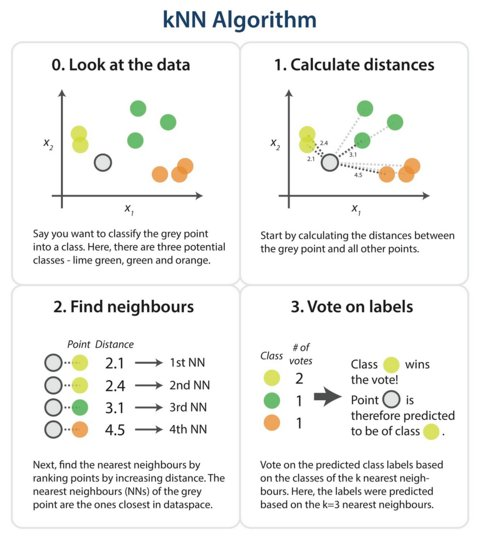

In [43]:
Image("knn.jpg")

For passing our sparse matrix into KNN we need to convert it into CSR

CSR divides a sparse matrix into 3 arrays : values, extent of rows, index of columns

### Model building

In [36]:
purchase_matrix = csr_matrix(purchase_df.values)

# Creating KNN Model with metric parameter as euclidean distance
knn_model = NearestNeighbors(metric = 'euclidean', algorithm = 'brute')

# Fitting the model on purchase_matrix
knn_model.fit(purchase_matrix)

NearestNeighbors(algorithm='brute', metric='euclidean')

### Finding similar users

In [37]:
def fetch_similar_users_knn(purchase_df,query_index):
    
    # Creating empty list where we will store user id of similar users
    simular_users_knn = []
    
    # Storing the distance and index of nearest neighors
    distances, indices = knn_model.kneighbors(purchase_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 5)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(purchase_df.index[query_index]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, purchase_df.index[indices.flatten()[i]], distances.flatten()[i]))
            
            simular_users_knn.append(purchase_df.index[indices.flatten()[i]])  
    return simular_users_knn

In [38]:
simular_users_knn = fetch_similar_users_knn(purchase_df,1497)
simular_users_knn

Recommendations for 14729:

1: 16917, with distance of 8.12403840463596:
2: 16989, with distance of 8.12403840463596:
3: 15124, with distance of 8.12403840463596:
4: 12897, with distance of 8.246211251235321:


[16917, 16989, 15124, 12897]

### Making Recommendations

In [39]:
def knn_recommendation(simular_users_knn):
    
    #obtaining all the items bought by similar users
    knn_recommnedations = []
    for j in simular_users_knn:
        item_list = data1[data1["CustomerID"]==j]['StockCode'].to_list()
        knn_recommnedations.append(item_list)
    
    #this gives us multi-dimensional list
    # we need to flatten it
    flat_list = []
    for sublist in knn_recommnedations:
        for item in sublist:
            flat_list.append(item)
    final_recommendations_list = list(dict.fromkeys(flat_list))
    
    # storing 10 random recommendations in a list
    ten_random_recommendations = random.sample(final_recommendations_list, 10)
    
    print('Items bought by Similar users based on KNN')
    
    #returning 10 random recommendations
    return ten_random_recommendations

In [40]:
knn_recommendation(simular_users_knn)

Items bought by Similar users based on KNN


['22957',
 '22605',
 '22961',
 '22920',
 '22919',
 '22926',
 '84997A',
 '22470',
 '23298',
 '22469']

## Collaborative Filtering using Matrix Factorization

For Matrix Factorization, we are using the Surprise Package.

Surprise package: This package has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of Collaborative Filtering algorithms such as NMF, kNN, Co-Clustering, SVD.

In [203]:
data3 = items_purchase_df.stack().to_frame()

In [204]:
#Renaming the column as Quantity
data3 = data3.reset_index().rename(columns={0:"Quantity"})

In [205]:
data3

,StockCode,CustomerID,Quantity
0,10002,12346,0
1,10002,12347,0
2,10002,12348,0
3,10002,12350,0
4,10002,12352,0
...,...,...,...
12903081,POST,18280,0
12903082,POST,18281,0
12903083,POST,18282,0
12903084,POST,18283,0


In [220]:
print(items_purchase_df.shape)
print(data3.shape)

(3538, 3647)
(12903086, 3)


3877 unique items x 4339 unique customer ids

Total records in data3 should be 3877x4339 = 1,68,22,303

And this size is too big to pass into an algorithm so we need to reduce the size of dataset by shortlisting.

### Shortlisting customers & items based on no. of orders

In [206]:
# Storing all customer ids in customers
customer_ids = data1['CustomerID']

# Storing all item descriptions in items
item_ids = data1['StockCode']

In [207]:
from collections import Counter

In [208]:
# counting no. of orders made by each customer
count_orders = Counter(customer_ids)

# storing the count and customer id in a dataframe
customer_count_df = pd.DataFrame.from_dict(count_orders, orient='index').reset_index().rename(columns={0:"Quantity"})

# dropping all customer ids with less than 120 orders
customer_count_df = customer_count_df[customer_count_df["Quantity"]>120]

# renaming the index column as CustomerID for inner join
customer_count_df.rename(columns={'index':'CustomerID'},inplace=True)

In [209]:
customer_count_df

,CustomerID,Quantity
0,17850,297
1,13047,140
2,12583,182
6,14688,265
8,15311,1892
...,...,...
3308,14096,1170
3367,16910,261
3392,16360,226
3413,17728,133


In [210]:
# counting no. of times an item was ordered
count_items = Counter(item_ids)

# storing the count and item description in a dataframe
item_count_df = pd.DataFrame.from_dict(count_items, orient='index').reset_index().rename(columns={0:"Quantity"})

# dropping all items which were ordered less than 120 times
item_count_df = item_count_df[item_count_df["Quantity"]>120]

# renaming the index column as Description for inner join
item_count_df.rename(columns={'index':'StockCode'},inplace=True)

In [211]:
item_count_df

,StockCode,Quantity
0,84029E,161
1,71053,220
3,84406B,213
4,22752,229
5,85123A,1606
...,...,...
3295,23294,181
3296,23295,213
3363,23328,129
3373,23356,148


Applying inner join

In [212]:
data4 = pd.merge(data3, item_count_df, on='StockCode', how='inner')
data4 = pd.merge(data4, customer_count_df, on='CustomerID', how='inner')

In [213]:
data4

,StockCode,CustomerID,Quantity_x,Quantity_y,Quantity
0,10133,12347,0,124,124
1,15036,12347,0,278,124
2,15056BL,12347,0,223,124
3,15056N,12347,0,325,124
4,16156S,12347,0,137,124
...,...,...,...,...,...
385667,85132C,18283,0,127,447
385668,85150,18283,1,264,447
385669,85152,18283,1,466,447
385670,M,18283,1,198,447


In [214]:
# dropping columns which are not necessary
data4.drop(['Quantity_y','Quantity_x'],axis=1,inplace=True)

In [215]:
data4

,StockCode,CustomerID,Quantity
0,10133,12347,124
1,15036,12347,124
2,15056BL,12347,124
3,15056N,12347,124
4,16156S,12347,124
...,...,...,...
385667,85132C,18283,447
385668,85150,18283,447
385669,85152,18283,447
385670,M,18283,447


In [216]:
    data4.describe()

,CustomerID,Quantity
count,385672.000000,385672.000000
mean,15360.985915,279.089789
std,1719.468125,337.879413
min,12347.000000,121.000000
25%,13996.250000,151.000000
50%,15413.000000,198.000000
75%,16840.000000,290.000000
max,18283.000000,5095.000000


This is how the data4 looks like. We have reduced the size from 1,68,22,303 to 3,85,672.

This format is exactly what is suitable to be passed into surprise library.

In [236]:
# reading the data in a format supported by surprise library.
reader = Reader(rating_scale=(0,5095))
# the range has been set as 0,5095 as the maximum value of quantity is 5095.

# loading Dataset in a format supported by surprise library.
formated_data = Dataset.load_from_df(data4, reader)

In [238]:
# performing train test split on the dataset
train_set, test_set = train_test_split(formated_data, test_size= 0.2)


### Implementing NMF

In [86]:
# defining the model
algo1 = NMF()

# model fitting
algo1.fit(train_set)

# model prediction
pred1 = algo1.test(test_set)

In [87]:
accuracy.rmse(pred1)

accuracy.mae(pred1)

RMSE: 428.3167
MAE:  272.6909


272.69085113731455

In [88]:
cross_validate(algo1, formated_data, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    408.7863439.8140413.9594454.8171421.4936427.774117.1296 
MAE (testset)     266.9103275.0543274.2514275.6236271.2964272.62723.2237  
Fit time          0.13    0.13    0.12    0.13    0.14    0.13    0.00    
Test time         0.03    0.03    0.03    0.02    0.03    0.03    0.00    


{'test_rmse': array([408.78632846, 439.81403253, 413.95935583, 454.8170914 ,
        421.4936362 ]),
 'test_mae': array([266.91033813, 275.05428962, 274.25142647, 275.62360746,
        271.29635055]),
 'fit_time': (0.12910890579223633,
  0.12529301643371582,
  0.12463021278381348,
  0.12522602081298828,
  0.13525986671447754),
 'test_time': (0.031000375747680664,
  0.025072097778320312,
  0.0260007381439209,
  0.024999380111694336,
  0.028090238571166992)}

### Implementing Co-Clustering

In [89]:
# defining the model
algo2 = CoClustering()

# model fitting
algo2.fit(train_set)

# model prediction
pred2 = algo2.test(test_set)

In [90]:
accuracy.rmse(pred2)

accuracy.mae(pred2)

RMSE: 6.7877
MAE:  5.8950


5.894957413478744

In [91]:
cross_validate(algo2, formated_data, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    6.8485  6.6710  34.0950 11.0666 11.4735 14.0309 10.2338 
MAE (testset)     5.6185  5.0401  7.0667  7.0208  5.9296  6.1352  0.7950  
Fit time          0.19    0.17    0.18    0.20    0.18    0.18    0.01    
Test time         0.01    0.01    0.02    0.01    0.01    0.01    0.00    


{'test_rmse': array([ 6.84846834,  6.67101634, 34.09501954, 11.06659857, 11.47345859]),
 'test_mae': array([5.6185295 , 5.04010775, 7.06674848, 7.02078426, 5.92962437]),
 'fit_time': (0.19111895561218262,
  0.17113018035888672,
  0.18015193939208984,
  0.20217561721801758,
  0.17614531517028809),
 'test_time': (0.012076377868652344,
  0.012494802474975586,
  0.015130758285522461,
  0.011000633239746094,
  0.010999441146850586)}

### Implementing SVD

In [92]:
# defining the model
algo3 = SVD()

# model fitting
algo3.fit(train_set)

# model prediction
pred3 = algo3.test(test_set)

In [93]:
accuracy.rmse(pred3)
accuracy.mae(pred3)

RMSE: 4827.6830
MAE:  4815.8341


4815.834066901409

In [94]:
cross_validate(algo3, formated_data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4826.94774824.54614833.98094821.32784831.92764827.74604.6568  
MAE (testset)     4814.74194812.78874823.29514807.17674821.54864815.91025.8943  
Fit time          0.11    0.10    0.10    0.10    0.10    0.10    0.00    
Test time         0.04    0.04    0.04    0.04    0.04    0.04    0.00    


{'test_rmse': array([4826.94766675, 4824.54612649, 4833.98090426, 4821.32781799,
        4831.92760779]),
 'test_mae': array([4814.74185739, 4812.78873239, 4823.29511444, 4807.17671655,
        4821.54863556]),
 'fit_time': (0.11000823974609375,
  0.10299897193908691,
  0.10299897193908691,
  0.10199928283691406,
  0.10222578048706055),
 'test_time': (0.03799724578857422,
  0.03700089454650879,
  0.03699946403503418,
  0.03699827194213867,
  0.03599977493286133)}

### Testing the models

In [196]:
#taking item 47590B and customer 15738 for testing
data1[(data1['StockCode']=='47590B')&(data1['CustomerID']==15738)].Quantity.sum()

78

In [198]:
algo1.test([['47590B',15738,78]])

# Predicted value given out by model is 3.08 while actual was 78

[Prediction(uid='47590B', iid=15738, r_ui=78, est=3.0822798420286723, details={'was_impossible': False})]

In [197]:
algo2.test([['47590B',15738,78]])

# Predicted value given out by model is 133.01 while actual was 78

[Prediction(uid='47590B', iid=15738, r_ui=78, est=133.01087456331527, details={'was_impossible': False})]

In [200]:
algo3.test([['47590B',15738,78]])

# Predicted value given out by model is 5095 while actual was 78

[Prediction(uid='47590B', iid=15738, r_ui=78, est=5095, details={'was_impossible': False})]

### Giving out predictions

In [102]:
pred2

# Predictions given out by Co-Clustering

[Prediction(uid='85014B', iid=17228, r_ui=130.0, est=119.18329013727276, details={'was_impossible': False}),
 Prediction(uid='84406B', iid=16520, r_ui=156.0, est=161.85867140088936, details={'was_impossible': False}),
 Prediction(uid='47590B', iid=17365, r_ui=353.0, est=352.7773176826455, details={'was_impossible': False}),
 Prediction(uid='85049G', iid=16755, r_ui=170.0, est=159.5403752414615, details={'was_impossible': False}),
 Prediction(uid='16156S', iid=14895, r_ui=367.0, est=368.129814201444, details={'was_impossible': False}),
 Prediction(uid='47566B', iid=17238, r_ui=384.0, est=393.60123986750034, details={'was_impossible': False}),
 Prediction(uid='47590A', iid=15708, r_ui=235.0, est=230.66948724769583, details={'was_impossible': False}),
 Prediction(uid='84030E', iid=13798, r_ui=271.0, est=274.235011964956, details={'was_impossible': False}),
 Prediction(uid='85099B', iid=15311, r_ui=1892.0, est=1895.5766313663817, details={'was_impossible': False}),
 Prediction(uid='85099F'

In [119]:
def get_item_orders(user_id):
    try:
        # for an item, return the no. of orders made
        return len(train_set.ur[train_set.to_inner_uid(user_id)])
    except ValueError:
        # user not present in training
        return 0
    
def get_customer_orders(item_id):
    try:
        # for an customer, return the no. of orders made
        return len(trainset.ir[train_set.to_inner_iid(item_id)])
    except ValueError:
        # item not present in training
        return 0

### Best and Worst Predictions made by Co-Clustering

In [120]:
predictions_data = pd.DataFrame(pred2, columns=['item_id', 'customer_id', 'quantity', 'prediction', 'details'])
predictions_data['item_orders'] = predictions_data.item_id.apply(get_item_orders)
predictions_data['customer_orders'] = predictions_data.customer_id.apply(get_customer_orders)
predictions_data['error'] = abs(predictions_data.prediction - predictions_data.quantity)
best_predictions = predictions_data.sort_values(by='error')[:10]
worst_predictions = predictions_data.sort_values(by='error')[-10:]

In [121]:
predictions_data

,item_id,customer_id,quantity,prediction,details,item_orders,customer_orders,error
0,85014B,17228,130.0,119.183290,{'was_impossible': False},459,31,10.816710
1,84406B,16520,156.0,161.858671,{'was_impossible': False},459,29,5.858671
2,47590B,17365,353.0,352.777318,{'was_impossible': False},457,32,0.222682
3,85049G,16755,170.0,159.540375,{'was_impossible': False},450,32,10.459625
4,16156S,14895,367.0,368.129814,{'was_impossible': False},440,30,1.129814
...,...,...,...,...,...,...,...,...
4539,47590B,15764,180.0,179.777318,{'was_impossible': False},457,30,0.222682
4540,84970L,16222,137.0,144.853747,{'was_impossible': False},458,34,7.853747
4541,84596F,16340,153.0,154.254839,{'was_impossible': False},453,29,1.254839
4542,85099B,17511,745.0,748.576631,{'was_impossible': False},447,32,3.576631


In [122]:
best_predictions

,item_id,customer_id,quantity,prediction,details,item_orders,customer_orders,error
334,16156S,17841,5095.0,5095.000000,{'was_impossible': False},440,32,0.000000
3973,47590B,13230,457.0,456.777318,{'was_impossible': False},457,29,0.222682
697,47590B,12415,601.0,600.777318,{'was_impossible': False},457,30,0.222682
2339,47590B,13869,307.0,306.777318,{'was_impossible': False},457,34,0.222682
1572,47590B,13078,276.0,275.777318,{'was_impossible': False},457,32,0.222682
1608,47590B,17428,299.0,298.777318,{'was_impossible': False},457,35,0.222682
1160,47590B,17799,343.0,342.777318,{'was_impossible': False},457,31,0.222682
574,47590B,17337,543.0,542.777318,{'was_impossible': False},457,29,0.222682
4000,47590B,14527,694.0,693.777318,{'was_impossible': False},457,35,0.222682
516,47590B,14701,238.0,237.777318,{'was_impossible': False},457,31,0.222682


In [221]:
worst_predictions

,item_id,customer_id,quantity,prediction,details,item_orders,customer_orders,error
4003,47599A,14286,141.0,125.720820,{'was_impossible': False},471,34,15.279180
2939,47599A,15696,122.0,106.720820,{'was_impossible': False},471,28,15.279180
2933,47599A,16393,214.0,198.720820,{'was_impossible': False},471,32,15.279180
538,47599A,12662,157.0,141.720820,{'was_impossible': False},471,32,15.279180
537,47599A,14040,178.0,162.720820,{'was_impossible': False},471,31,15.279180
2180,47599A,14808,208.0,192.720820,{'was_impossible': False},471,31,15.279180
1585,47599A,13555,136.0,120.720820,{'was_impossible': False},471,30,15.279180
3252,47599A,14911,3648.0,3632.720820,{'was_impossible': False},471,34,15.279180
1651,47599A,13089,1511.0,1495.720820,{'was_impossible': False},471,31,15.279180
3033,47599A,12949,179.0,163.009478,{'was_impossible': False},471,31,15.990522


In [225]:
# Getting item list for user 12347
item_list = predictions_data[predictions_data['customer_id']==12347]['item_id'].values.tolist()
item_list

['82494L', '84970S', '47599A', '84997B', '85123A', '84997C', '85049A']

In [235]:
# Getting list of uique customers who also bught same items (item_list)
customer_list = predictions_data[predictions_data['item_id'].isin(item_list)]['customer_id'].values
customer_list = np.unique(customer_list).tolist()
customer_list

[12347,
 12362,
 12370,
 12378,
 12415,
 12417,
 12428,
 12433,
 12444,
 12449,
 12451,
 12471,
 12472,
 12474,
 12476,
 12477,
 12481,
 12484,
 12490,
 12502,
 12517,
 12520,
 12539,
 12540,
 12553,
 12567,
 12583,
 12621,
 12626,
 12662,
 12668,
 12682,
 12683,
 12688,
 12700,
 12705,
 12708,
 12709,
 12720,
 12721,
 12731,
 12744,
 12748,
 12757,
 12766,
 12839,
 12841,
 12867,
 12921,
 12949,
 12957,
 12971,
 13001,
 13004,
 13013,
 13047,
 13050,
 13069,
 13078,
 13089,
 13093,
 13097,
 13098,
 13102,
 13113,
 13124,
 13137,
 13139,
 13148,
 13178,
 13184,
 13198,
 13209,
 13232,
 13263,
 13266,
 13267,
 13268,
 13269,
 13285,
 13319,
 13334,
 13381,
 13418,
 13451,
 13458,
 13505,
 13507,
 13534,
 13548,
 13555,
 13593,
 13610,
 13634,
 13694,
 13700,
 13709,
 13764,
 13777,
 13815,
 13842,
 13862,
 13869,
 13871,
 13881,
 13901,
 13908,
 13911,
 13952,
 13969,
 13975,
 13985,
 13988,
 13999,
 14016,
 14030,
 14031,
 14040,
 14044,
 14049,
 14051,
 14056,
 14057,
 14060,
 14081,


In [233]:
# filtering those customers from predictions data
filtered_data = predictions_data[predictions_data['customer_id'].isin(customer_list)]

# removing the items already bought
filtered_data = filtered_data[~filtered_data['item_id'].isin(item_list)]

# getting the top items (prediction)
recommended_items = filtered_data.sort_values('prediction',ascending=False).reset_index(drop=True).head(10)['item_id'].values.tolist()
recommended_items

['16156S',
 '85049E',
 '47504K',
 '85099C',
 '85049G',
 '85014B',
 '72351B',
 '84536A',
 '48173C',
 '47590A']